In [1]:
# Importing the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickles
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Importing the necessary machine learning packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

#### Notes:

Why are using the f1 score:
- The most popular classification scoring metric would likely be accuracy. However, the flaw with accuracy is that takes into account that a dataset could unbalanced. An unbalanced dataset does not have an even distribution among the potential target variables.
- This presents a problem because if are measuring cancer patients, we are likely to have more people without cancer than with cancer. 
    - In our example, there are 100 people without cancer and 10 people with cancer.
    - Without doing any machine learning models, we can predict that all the users will not have cancer.
    - If we accuracy, our score would be 100/110 or 91 percent (accurate prediction/total predictions).
- The basic example above describes why using accuracy is not the best measure when we have unbalanced dataset.

In [3]:
final = pd.read_pickle("./pickles/final.pkl")
test_set = pd.read_pickle("./pickles/test.pkl")
final.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,escolari/age-std,escolari/age-range_,instl_var/age-max,instl_var/age-std,instl_var/age-range_,tech_gadgets-min,tech_gadgets-sum,tech_gadgets-std,tech_gadgets-range_,female-head
0,0,0,1,1,1,0,0,0,0,0,...,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0,0
1,0,0,1,1,0,0,0,0,0,1,...,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0,0
2,0,0,1,1,0,0,0,0,0,1,...,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0,1
3,0,0,1,1,1,0,0,0,0,0,...,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0,0
4,1,0,1,1,1,0,0,0,0,0,...,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0,0


In [4]:
# Labels for training (Excluding where the target is null)
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extracting the training set (target is not null for target variable)
train_on = final[final['Target'].notnull()]
train_on.drop(['Id', 'idhogar', 'Target'], axis=1, inplace=True)

# Extracting the testing set (target is null for target variable)
test_on = final[final['Target'].isnull()]
test_on.drop(['Id', 'idhogar', 'Target'], axis=1, inplace=True)

# Submission base which is used for making submissions to the competition
submission_base = test_set[['Id', 'idhogar']].copy()

/Users/alexguanga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alexguanga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [5]:
# Storing the features
features = list(train_on.columns)

# Creating a machine learning pipeline to be applied to the columns in our dataframe
pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_on = pipeline.fit_transform(train_on)
test_on = pipeline.transform(test_on)

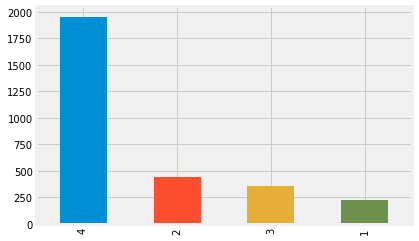

In [6]:
# Distribution of the count labels across the target variables
pd.DataFrame({'train_labels': train_labels})['train_labels'].value_counts().plot(kind='bar')

In [7]:
# Quick Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1)

# 10 fold cross validation
cv_score = cross_val_score(model, train_on, train_labels, cv=10, scoring=scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3405 with std = 0.0395


#### Notes 
- It's always important to establish the baseline for performance. The Random Forest model trained above offers us a baseline of an F1 Score of .3405. If we cannot have a stronger performance, then our model is not being computed as efficiently as it could.

## Feature Importance
An importance concept is discovering the features that bring value to our model. If a feature does not add any value to the machine learning model, you should consider removing the feature as it could add be decreasing the performance of our model as it could overfit with additional features.

In [8]:
model.fit(train_on, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.sort_values(by="importance", ascending=False).head(5)

,feature,importance
60,meaneduc,0.026357
195,age-min,0.022635
88,phones-per-capita,0.021832
196,age-max,0.021160
205,escolari/age-sum,0.020962


In [9]:
def plot_feature_importances(df, n = 10, threshold = None):
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 5),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (12, 4))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

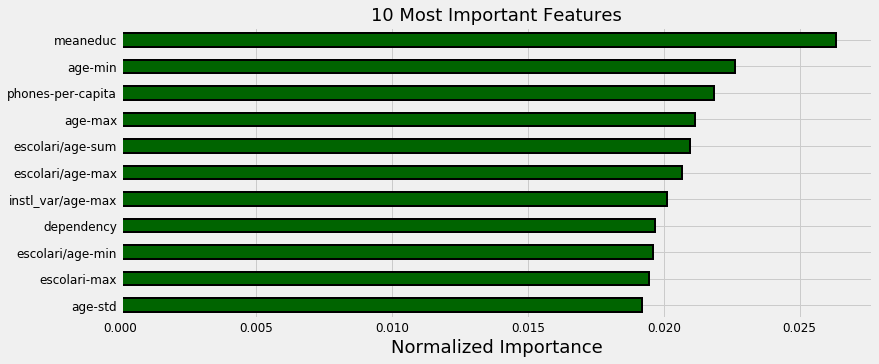

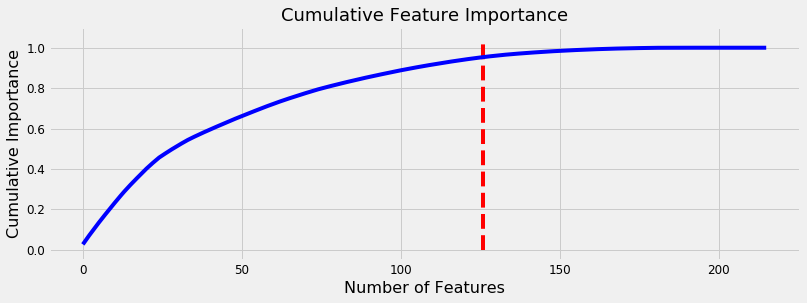

126 features required for 95% of cumulative importance.


In [10]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)


#### Notes:
- Realize that we do not need all the variable to have a high importance of the data
- Also, the importance does not tell its affect on the target variable
- Lastly, we need to be reassured of the variables that could be correlated with one another.

In [11]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}
    plt.figure(figsize = (14, 5))
    
    df = df[df['Target'].notnull()]
    
    # Looping through the target variables
    for level in df['Target'].unique():
        
        # Creating a copy of the dataframe filtered by each target variable
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

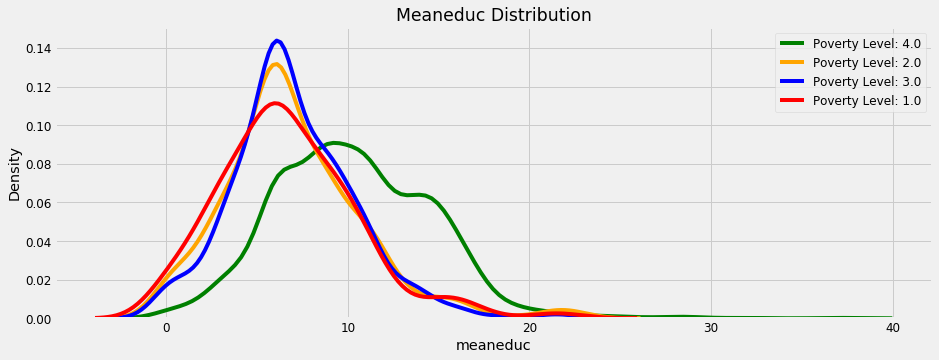

In [12]:
# Calculating the target variable distribution for "meaneduc"
kde_target(final, 'meaneduc')

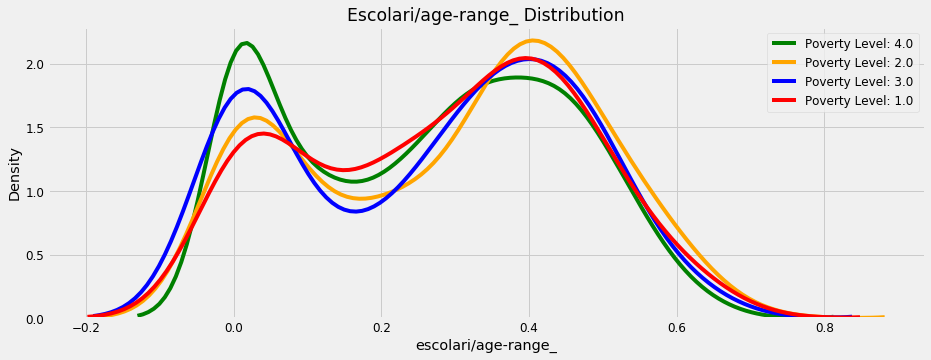

In [13]:
# Calculating the target variable distribution for "escolari/age-range_"
kde_target(final, 'escolari/age-range_')

## Modeling

We will be working with several models which will allow us to see which model offers better performance. We can also time the performance... to understand the trade-off between performance and computation efficiency.

Overview of models:
1. Linear SVC: A Linear Suppport Vector Machine. Without digging into the details, a support vector machine tries to split the data values by its target variable optimizing towards maximizing the margin between the target variables. If we were to have two potential target variables, you can think of drawing a line between the data values. Mathematically, the line is calculated by having the greatest margin between the data values of each potential target variable and the line known as the Decision Boundary.
2. GaussianNB: Gaussian Naive Bayes is build from the Bayes Theorem. The model is trained where it uses probability. For example, if you are predicting a person's level of poverty, we would look at the historical probability. If the new person has a car and historically data indicates that 12% of people with cars have 
3. MLPClassifier: A Multilayer perceptron is an artificial neural network. Meaning, it consists of at least three layers (input, hidden, and output). A neural network is like creating many functions. Within each function, through backward propogation, the model will optimized the weights or betas.
4. LogisticRegressionCV: Logistic Regression is a probalisitic method that assigns a probability to each potential target variable. A logistic regression is a unique function because it "squishes" the value to be between 0 and 1.
5. RidgeClassifierCV: TBD
6. LinearDiscriminantAnalysis: The Linear Discriminant Analysis is a two-part computation. It reduces the features used while maximizing the difference between the mean of the target variable. However, it must also attempt to minimize the variance of each target variable.
7. KNeigbhorsClassifier: K-Neigbors is a model that focuses on using the features that are geometrically close to the data value you are predicting. If calculated on a 2-D graph, we will compute the Euclidean distance to get the x number of neigbors. It then uses the target variable of the data values that are close to the prediction data value.
8. ExtraTreeClassifier: Similar to a Random Forest, it uses Decision Trees to buid it model. Unlike a Random Forest, an Extra Tree Classifier does not relay on bootstrapping the dataset. Rather, it uses the entire dataset. One advantage of using the entire dataset is that it reduces bias because with the model is build with more data. More data can help a model reduce bias by introducing more features!

In [14]:
# Importing model-related libraries
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [15]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe that will the hold result for different models
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                           'cv_std': cv_scores.std()},
                                                           index = [0]), ignore_index = True)

        return model_results

#### LSVC Model

In [16]:
# LSVC Model
model_results = cv_model(train_on, train_labels, LinearSVC(), 'LSVC', model_results)

10 Fold CV Score: 0.29056 with std: 0.0489


#### Gaussian Model

In [17]:
# Gaussian Model
model_results = cv_model(train_on, train_labels, GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.1958 with std: 0.04638


#### The multi-layer perceptron

In [18]:
# The multi-layer perceptron
model_results = cv_model(train_on, train_labels, MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.31365 with std: 0.06378


#### LinearDiscriminantAnalysis

In [19]:
# If you run LinearDiscriminantAnalysis without filtering out the UserWarnings, you get many messages saying 
# "Variables are collinear." This might give us a hint that we want to remove some collinear features! 

model_results = cv_model(train_on, train_labels, LinearDiscriminantAnalysis(), 'LDA', model_results)

10 Fold CV Score: 0.31704 with std: 0.06514


#### Ridge Regression

In [20]:
# Ridge Regression
model_results = cv_model(train_on, train_labels, RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27786 with std: 0.03989


#### KNN

In [21]:
# KNN Model with three parameters
for n in [2, 10, 20]:
    print(f'\nKNN with {n} neighbors')
    model_results = cv_model(train_on, train_labels, KNeighborsClassifier(n_neighbors=n), f'KK-{n}', model_results)
          


KNN with 2 neighbors
10 Fold CV Score: 0.32057 with std: 0.03758

KNN with 10 neighbors
10 Fold CV Score: 0.32686 with std: 0.0315

KNN with 20 neighbors
10 Fold CV Score: 0.31206 with std: 0.0425


#### Extra Tree

In [22]:
# Extra Tree Classifier
model_results = cv_model(train_on, train_labels, ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.32839 with std: 0.04611


#### Random Forest

In [23]:
# Random Forest Classifier
model_results = cv_model(train_on, train_labels, RandomForestClassifier(100, random_state=10),
                         'RF', model_results)

10 Fold CV Score: 0.34053 with std: 0.0395


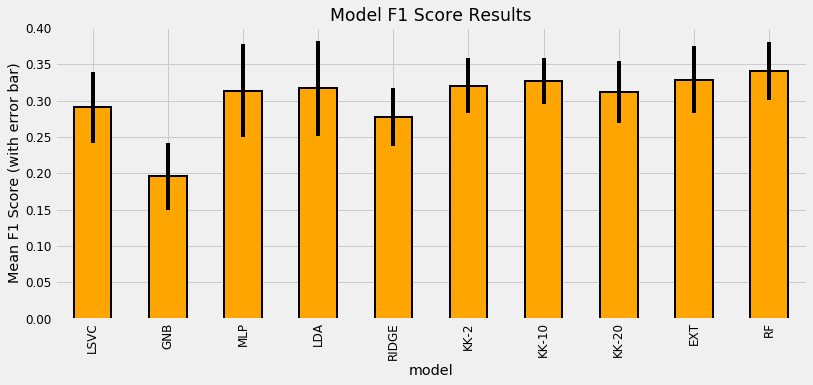

In [26]:
# Plotting performance across all the models

model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (12, 5),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');

In [27]:
# Reseting the index
model_results.reset_index(inplace=True)

## Submission

The submission_base will have all the individuals in the test set since we have to have a "prediction" for each individual while the test_ids will only contain the idhogar from the heads of households. When predicting, we only predict for each household and then we merge the predictions dataframe with all of the individuals on the household id (idhogar). This will set the Target to the same value for everyone in a household. For the test households without a head of household, we can just set these predictions to 4 since they will not be scored.

In [28]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])


In [29]:
def submit(model, train, train_labels, test, test_ids):
    """Train and test a model on the dataset"""
    
    # Train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions})

     # Make a submission dataframe
    submission = submission_base.merge(predictions, 
                                       on = 'idhogar',
                                       how = 'left').drop(columns = ['idhogar'])
    
    # Fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission 

In [30]:
def get_corrs_matrix(data, corr_threshold=.95):
    corr_matrix = data.corr()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [c for c in upper.columns if any(abs(upper[c]) > corr_threshold)]
    return [corr_matrix, to_drop]

In [31]:
# Removing features that have high inter-correlation

train_on = pd.DataFrame(train_on, columns=features)
corr_matrix, to_drop = get_corrs_matrix(train_on)
to_drop

['v18q-count', 'female-sum']

In [32]:
train_on = train_on.drop(to_drop, axis=1)
train_on.shape

(2973, 214)

In [33]:
# Setting up the testing set
test_on = pd.DataFrame(test_on, columns=features)
train_on, test_on = train_on.align(test_on, axis=1, join='inner')
features = list(train_on.columns)

### Model Improvement: Recursive Feature Elimination with Random Forest
- Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_ attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.

In [34]:
from sklearn.feature_selection import RFECV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state=10, n_estimators=100,  n_jobs=-1)

# Create the object
selector = RFECV(estimator, step=1, cv=3, scoring=scorer, n_jobs=-1)

In [35]:
# Fitting the object with the RF model
selector.fit(train_on, train_labels)

RFECV(cv=3,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
   n_jobs=-1, scoring=make_scorer(f1_score, average=macro), step=1,
   verbose=0)

56

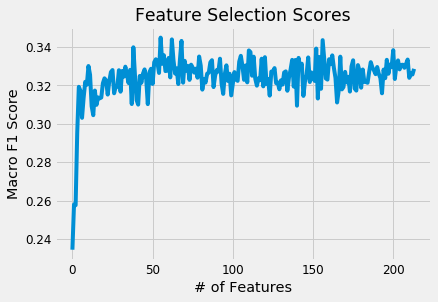

In [36]:
# Plotting the Recursive Feature Elimination
plt.plot(selector.grid_scores_);
plt.xlabel('# of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores')

selector.n_features_

In [37]:
# The ranking of the features
rankings = pd.DataFrame({'feature': train_on.columns.tolist(), 
                        'rank': selector.ranking_.tolist()}).sort_values('rank')
rankings.head(10)

,feature,rank
101,female-std,1
90,rooms-per-capita,1
195,age-sum,1
194,age-max,1
82,walls,1
179,instlevel8-sum,1
122,estadocivil7-std,1
192,escolari-range_,1
88,phones-per-capita,1
48,lugar1,1


In [38]:
# Training the model with the features that are labeled (train_on)
train_selected = selector.transform(train_on)
test_selected = selector.transform(test_on)

# Only selecting the features that are of ranking of 1
selected_features = train_on.columns[np.where(selector.ranking_==1)]

# Dataframe with features that were selected and of ranking 1
train_selected = pd.DataFrame(train_selected, columns=selected_features)
test_selected = pd.DataFrame(test_selected, columns=selected_features)

# Performing a 10-CV the model with a Random Forest Classifier
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

10 Fold CV Score: 0.35515 with std: 0.04727


In [39]:
def plot_model_scores(model_results):
    model_results.set_index('model', inplace = True)
    model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6), 
                                      yerr = list(model_results['cv_std']),
                                      edgecolor = 'k', linewidth = 2)

    plt.title('Model F1 Score Results');
    plt.ylabel('Mean F1 Score (with error br)');
    model_results.reset_index(inplace = True)

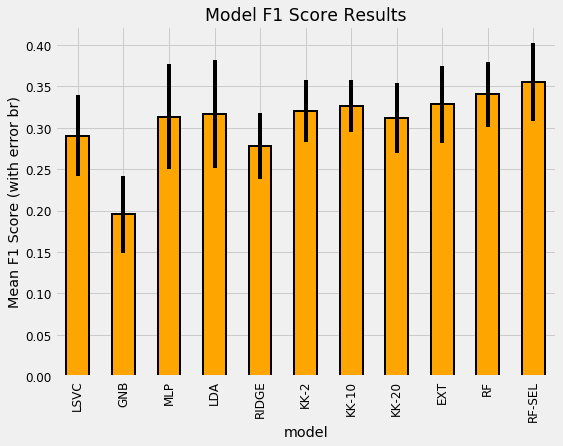

In [40]:
plot_model_scores(model_results)

## Advanced Modeling: Gradient Boosting Machine


From Blog Post:
- Choosing Number of Estimators with Early Stopping
    - To choose the number of estimators (the number of decision trees in the ensemble, called ``n_estimators`` or ``num_boost_rounds``), we'll use early stopping with 5-fold cross validation. This will keep adding estimators until the performance as measured by the Macro F1 Score has not increased for 100 training rounds. To use this metric, we'll have to define a custom metric.

In [41]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1).argmax(axis=0)
    
    metric_value = f1_score(labels, predictions, average='macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

###  Light Gradient Boosting Implementation

From Blog Post:
- Choosing hyperparameters for the Gradient Boosting Machine can be tough and generally is done through model optimization. 
- We set the ``n_estimators`` to 10000 but we won't actually reach this number because we are using ``early stopping`` which will quit training estimators when the cross validation metric does not improve for early_stopping_rounds. The display is used to show custom information during training in combination with %%capture so we don't have to see all the LightGBM information during training.

**Stratified kfold**
- Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole. For example in a binary classification problem where each class comprises 50% of the data, it is best to arrange the data such that in every fold, each class comprises around half the instances.

**Cross Validation with Early Stopping**
- Cross validation with early stopping is one of the most effective methods for preventing overfitting on the training set because it prevents us from continuing to add model complexity once it is clear that validation scores are not improving. Repeating this process across multiple folds helps to reduce the bias that comes from using a single fold. Early stopping also lets us train the model much quicker. 
    
**lightgbm**
- There are two methods when splitting the data. Some models might use a level-wise growth where every level has a split. The problem with this method is that this not necessary offer the most efficient splits. 
- We could be better off by splitting one branch continuously if it offers the greatest change in the criterion we use (Gini Impurity or Information Gain).
- LightGBM and XGBoost both use the latter method (leaf-wise growth). 
- After some reading, the XGBoost and LightGBM offer similar scoring performance. The biggest difference is the LightGBM trains its model much quicker (about 7x quicker). 
- The efficiency comes from Microsoft’s numerical cleverness. They are structuring the dataset to use less memory!


In [44]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, nfolds=5, return_preds=False, hyp=None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    # Storing the features
    feature_names = list(features.columns)

    # Option if user is providing hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of estimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    # Model hyperparameters
    else:
        params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                  'min_child_samples': 10, 
                  'num_leaves': 36, 'reg_alpha': 0.76, 
                  'reg_lambda': 0.43, 
                  'subsample_for_bin': 40000, 
                  'subsample': 0.54, 
                  'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective='multiclass', n_jobs=-1, 
                               n_estimators=10000, #n_estimators is 10000: large enough to have no affect
                               random_state=10)
    
    # Using Stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits=nfolds, shuffle=True)
    
    # Creating a dataframe for which our the predictionss will be stored for each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds=100, 
                  eval_metric=macro_f1_score,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_names=['train', 'valid'],
                  verbose=200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add the test_id and the fold to the dataframe 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions, we don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis=1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis=1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances along with validation scores
    return submission, feature_importances, valid_scores

In [46]:
%%capture --no-display
predictions, gbm_fi = model_gbm(train_on, train_labels, test_on, test_ids, return_preds=True)

'Fold 1, Validation Score: 0.40243, Estimators Trained: 13'

'Fold 2, Validation Score: 0.42386, Estimators Trained: 6'

'Fold 3, Validation Score: 0.43941, Estimators Trained: 80'

'Fold 4, Validation Score: 0.41807, Estimators Trained: 14'

'Fold 5, Validation Score: 0.38517, Estimators Trained: 4'

'5 cross validation score: 0.41379 with std: 0.01857.'

In [48]:
predictions.head(5)

,1,2,3,4,idhogar,fold,Target,confidence
0,0.235068,0.238070,0.234196,0.292666,72958b30c,1,4,0.292666
1,0.243334,0.238585,0.230932,0.287149,5b598fbc9,1,4,0.287149
2,0.243820,0.243867,0.251931,0.260382,1e2fc704e,1,4,0.260382
3,0.237880,0.234485,0.244663,0.282972,8ee7365a8,1,4,0.282972
4,0.239383,0.235652,0.233423,0.291542,ff69a6fc8,1,4,0.291542


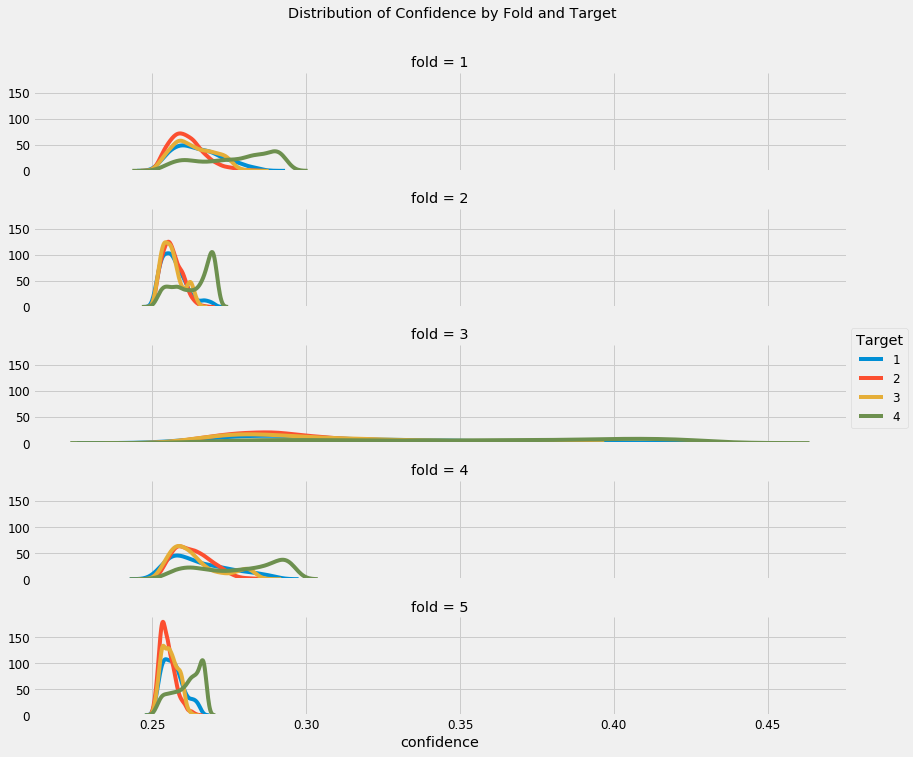

In [52]:
# Plotting the confidence, or highest probability, for each of the target for each of the folds
plt.rcParams['font.size'] = 12

# Visualizing it with a kde plot
g = sns.FacetGrid(predictions, row='fold', hue='Target', size=2, aspect=6)
g.map(sns.kdeplot, 'confidence');
g.add_legend();

plt.suptitle('Distribution of Confidence by Fold and Target', y = 1.05);

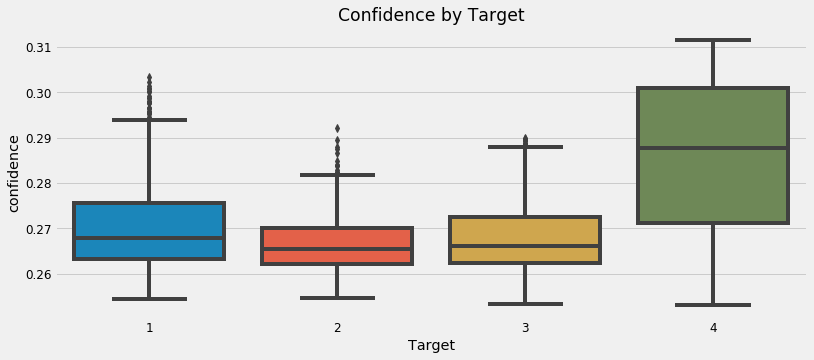

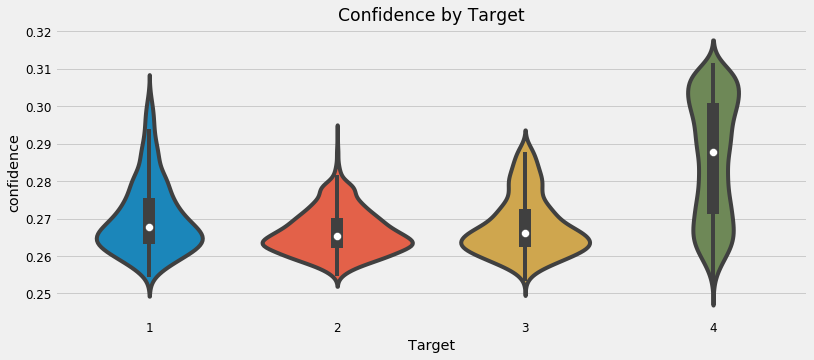

In [57]:
# Currently, our data is inbalanced, Target 4 has the mose values 
predictions = predictions.groupby('idhogar', as_index=False).mean()

# Getting the target index with the highest prob
predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis=1)

# Getting the target value with the highest prob
predictions['Confidence'] = predictions[[1, 2, 3, 4]].max(axis=1)

# Removing the specific fold
# predictions.drop('fold', axis=1, inplace=True)

# Plotting the confidence by each target
plt.figure(figsize = (12, 5))
sns.boxplot(x='Target', y='confidence', data=predictions);
plt.title('Confidence by Target');

plt.figure(figsize = (12, 5))
sns.violinplot(x='Target', y='confidence', data=predictions);
plt.title('Confidence by Target');

In [58]:
predictions.head(5)

,idhogar,1,2,3,4,Target,confidence,Confidence
0,000a08204,0.230463,0.234860,0.243083,0.291594,4,0.291594,0.291594
1,000bce7c4,0.255041,0.254263,0.247546,0.243150,1,0.256392,0.255041
2,001845fb0,0.227661,0.229813,0.235537,0.306989,4,0.306989,0.306989
3,003514e22,0.229440,0.239700,0.250452,0.280407,4,0.280407,0.280407
4,003b51a87,0.276372,0.251000,0.240714,0.231915,1,0.276675,0.276372


#### Notes:
- We can have the function instead return the actual submission file. This takes the average predictions across the five folds, in effect, it combines 5 different models, each one trained on a slghtly different subset of the data.

In [60]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_on, train_labels, 
                                             test_on, test_ids, return_preds=False)

submission.to_csv('gbm_baseline.csv')

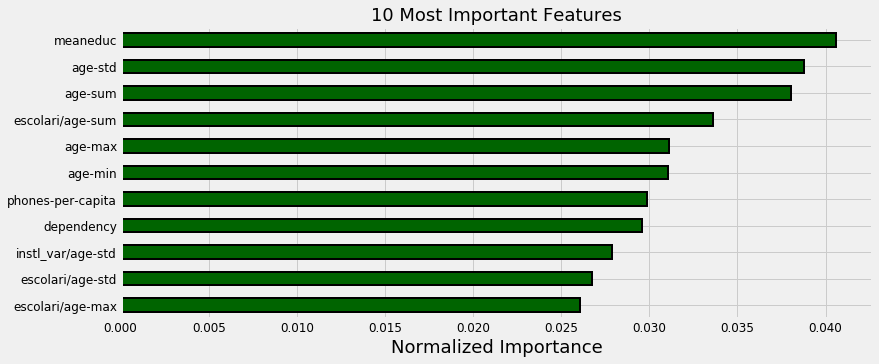

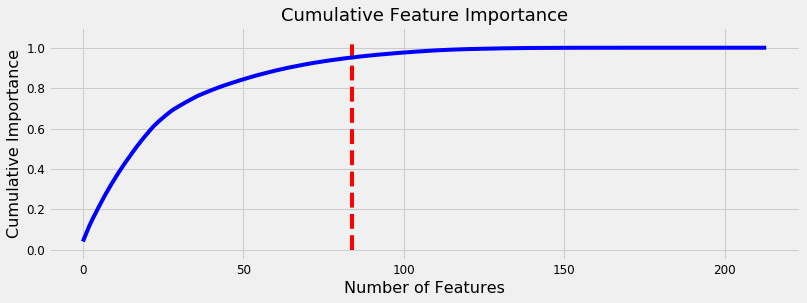

84 features required for 95% of cumulative importance.


In [61]:
_ = plot_feature_importances(gbm_fi, threshold=0.95)

In [62]:
%%capture --no-display

# Training the model with the selected features (after removing features that had a high inter-correlation)
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, 
                                                               test_selected, test_ids)

'Fold 1, Validation Score: 0.39708, Estimators Trained: 25'

'Fold 2, Validation Score: 0.43016, Estimators Trained: 275'

'Fold 3, Validation Score: 0.4228, Estimators Trained: 89'

'Fold 4, Validation Score: 0.4182, Estimators Trained: 21'

'Fold 5, Validation Score: 0.41004, Estimators Trained: 20'

'5 cross validation score: 0.41566 with std: 0.01135.'

In [64]:
# Append the result of previous to our dictionary
model_results = model_results.append(pd.DataFrame({'model': ["GBM", "GBM_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]}))

In [70]:
# Sorting the top performers based on the cv_mean
model_results.sort_values(by="cv_mean", ascending=False)

,cv_mean,cv_std,model
0,0.422089,0.020472,GBM
1,0.415658,0.011352,GBM_SEL
10,0.355147,0.047267,RF-SEL
9,0.340525,0.039503,RF
8,0.328392,0.046105,EXT
6,0.326863,0.031502,KK-10
5,0.320573,0.037579,KK-2
3,0.317038,0.065139,LDA
2,0.313648,0.063778,MLP
7,0.312065,0.042502,KK-20


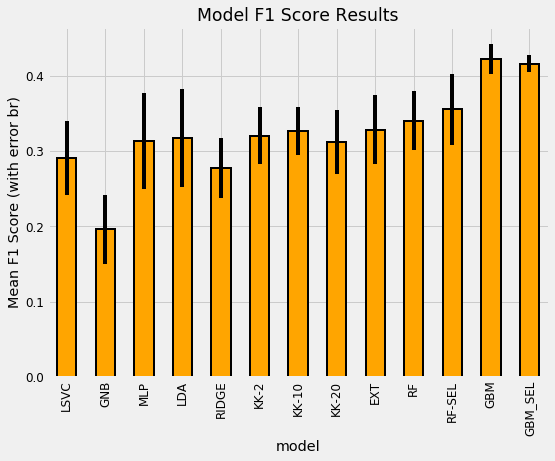

In [71]:
# Plotting the performance of our models
plot_model_scores(model_results)

#### Notes
- Performance was great but one way to improve our model is to use a 10-fold Cross-Validation technique. Hence, we would split the data into 10 subsets, train the model on 9 of those subsets, and then test it on the 1 subset.

In [72]:
%%capture

# Training the gbm model with a 10-fold
submission, gbm_fi_10fold, valid_scores = model_gbm(train_on, train_labels, test_on, test_ids, 
                                                    nfolds=10, return_preds=False)

In [58]:
# submission.to_csv('gbm_10fold.csv', index=False)

In [73]:
%%capture

# Training the gbm model with a 10-fold with the selected features
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, 
                                                               test_selected, test_ids,
                                                               nfolds=10)

In [60]:
# submission.to_csv('gmb_10fold_selected.csv', index = False)

In [74]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_10Fold", "GBM_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]}))

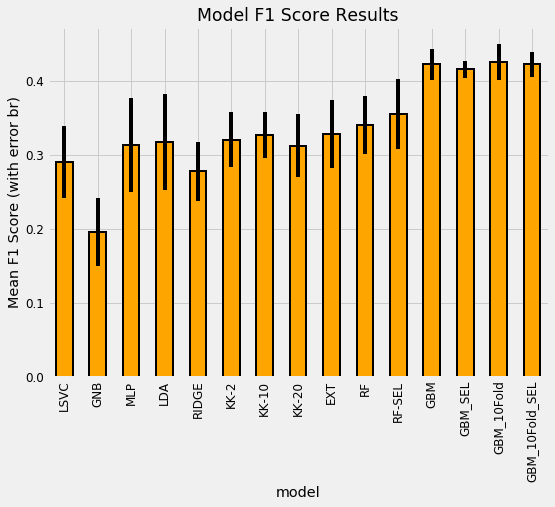

In [75]:
plot_model_scores(model_results)

#### Notes:
- The best model seems to be the Gradient Boosting Machine trained with 10 folds on the selected features. This model has not yet been optimized, but we might be able to get a little more performance through optimization.

In [76]:
print(f"There are {gbm_fi_selected[gbm_fi_selected['importance'] == 0].shape[0]} features with no importance.")

There are 0 features with no importance.


#### Notes:
- All of the features we are using have some importance to the Gradient Boosting Machine. It might be a good idea to go back and retry feature selection but with the GBM since that is the model we are using.

## Model Optimizations: Automated Optimization

**The one-sentence summary of Bayesian hyperparameter optimization is: build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.**

Two of the most prominent methods in discovering the hyperparameters in a model are `GridSearch` and `RandomSearch`. `GridSearch` is not an effective method because it computational expensive. It must evaulate the performance for every combination of hyperparameters. 

`RandomSearch` does a better job than `GridSearch` because it does not need to evaulate the performance of all the hyperparameters. For example, if we to to evaulate 5 `learning_rate` and 5 `mini_batch_size`, that's already 25 combinations. Yet, we are only evaulating 5 learning rates. Whereas, if we use `RandomSearch`, we can calculate use evaulate across 25 learning rates. Of course, it's random and we cannot be 100% sure that their could of been a combination that could produce better results. However, researchers have shown that the trade-off in training all the methods and the computationally efficiency is not worth it!

However, the issue with `RandomSearch` and `GridSearch` is that it does not use the performance of well-performing hyperparameters. It would spend time on hyperparameters that are not efficient!

Bayesian hyperparameter optimization attempts to solve this conflict by using the hyperparameters that have demonstrated strong performance! The implementation involved several additional components.
- Please note that I'm no expert in the Bayesian hyperparameter optimization. I have an intutive idea of how the model works but there are mathematical concepts that require high-level of mathematics.
- The Bayesian hyperparameter does not use the objective function that prescribed by a typical machine learning model (RMLSE).
- It's computationally too expensive to use the objective function when we are dealing with many hyperparameters.
- Thus, we implement a surrogate function which is also called a response surface. It's the probaility representation of the objective function built using previous evaluations. 
    - There are several surrogate function that could be used: Gaussian Process, Random Forest regression, Tree-structured Parzen Estimator
    - Gaussian Process:
        - This surrogate function uses the gaussian distribution to get an idea of the posterior distribution of the data. It's a conditional probability that calculates the posterior distribution.
    
    
Source:
- https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
- https://towardsdatascience.com/the-intuitions-behind-bayesian-optimization-with-gaussian-processes-7e00fcc898a0

Bayesian optimization requires 4 parts:

1. Objective function: what we want to maximize (or minimize)
2. Domain space: region over which to search
3. Algorithm for choosing next hyperparameters: uses past results to suggest next values
4. Results history: saves the past results

In [64]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample

import csv
import ast
from timeit import default_timer as timer

### 1. Objective Function


In [65]:
def objective(hyperparameters, nfolds=5):
    """Return validation score from hyperparameters for LightGBM"""
    
    # Keep track of evals
    global ITERATION
    ITERATION += 1
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    subsample_freq = hyperparameters['boosting_type'].get('subsample_freq', 0)
    
    boosting_type = hyperparameters['boosting_type']['boosting_type']
    
    if boosting_type == 'dart':
        hyperparameters['drop_rate'] = hyperparameters['boosting_type']['drop_rate']
    
    # Subsample and subsample frequency to top level keys
    hyperparameters['subsample'] = subsample
    hyperparameters['subsample_freq'] = subsample_freq
    hyperparameters['boosting_type'] = boosting_type
    
    # Whether or not to use limit maximum depth
    if not hyperparameters['limit_max_depth']:
        hyperparameters['max_depth'] = -1
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['max_depth', 'num_leaves', 'subsample_for_bin', 
                           'min_child_samples', 'subsample_freq']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Convert to arrays for indexing
    features = np.array(train_selected)
    labels = np.array(train_labels).reshape((-1 ))
    
    valid_scores = []
    best_estimators = []
    run_times = []
    
    model = lgb.LGBMClassifier(**hyperparameters, class_weight = 'balanced',
                               n_jobs=-1, metric = 'None',
                               n_estimators=10000)
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        start = timer()
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score, 
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 400)
        end = timer()
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        best_estimators.append(model.best_iteration_)
        
        run_times.append(end - start)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    loss = 1 - score
    
    run_time = np.mean(run_times)
    run_time_std = np.std(run_times)
    
    estimators = int(np.mean(best_estimators))
    hyperparameters['n_estimators'] = estimators
    
    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, score, score_std])
    of_connection.close()
    
    # Display progress
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {round(score, 4)}.')
    
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'time': run_time, 'time_std': run_time_std, 'status': STATUS_OK, 
            'score': score, 'score_std': score_std}

### 2. Search Space

The search space is probably the most important to configure. There are several things to keep in mind. 

We typically have 4 main domain distribution. Your decision of domain distribution should depend on the hyperparameter. For example, the number of leaves will most likely have `quniform` distribution because we should assign an equal probability to the values within the search spaces.

However, the learning rate should not have a `quniform` distribution because the learning rate should not all the an equal distribution among the sample subspace. Why? Well, if our range was between 0 and 1, the distribution between .9 and .95 and 0.05 and .1 should not be the same. There should a be larger probability that a smaller learning rate should be optimal! Smaller learning rates have shown to have greater influence on performance that larger learning rates.


In [66]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                              [{'boosting_type': 'gbdt', 
                                'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
                                'subsample_freq': hp.quniform('gbdt_subsample_freq', 1, 10, 1)}, 
                               {'boosting_type': 'dart', 
                                 'subsample': hp.uniform('dart_subsample', 0.5, 1),
                                 'subsample_freq': hp.quniform('dart_subsample_freq', 1, 10, 1),
                                 'drop_rate': hp.uniform('dart_drop_rate', 0.1, 0.5)},
                                {'boosting_type': 'goss',
                                 'subsample': 1.0,
                                 'subsample_freq': 0}]),
    'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
    'max_depth': hp.quniform('max_depth', 1, 40, 1),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', 
                                   np.log(0.025), 
                                   np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0)
}

In [67]:
sample(space)

{'boosting_type': {'boosting_type': 'goss',
  'subsample': 1.0,
  'subsample_freq': 0},
 'colsample_bytree': 0.5709365274312216,
 'learning_rate': 0.031697939669080015,
 'limit_max_depth': False,
 'max_depth': 9.0,
 'min_child_samples': 40.0,
 'num_leaves': 15.0,
 'reg_alpha': 0.21485206223069397,
 'reg_lambda': 0.23618753936058567,
 'subsample_for_bin': 14000.0}

### 3. Algorithm

The algorithm for choosing the next values is the Tree Parzen Estimator which uses Bayes rule for constructing a surrogate model of the objective function. Instead of maximizing the objective function, the algorithm maximizes the Expected Improvement (EI) of the surrogate model.

In [68]:
algo = tpe.suggest

### 4. Results History

We'll use two different methods for recording results:
- Trials object: stores everything returned from the objective function
- Write to a csv file on every iteration


I like using multiple methods for tracking progress because it means redundancy. One way may fail, but hopefully both will not! The csv file can be used to monitor the method while it is running and the Trials object can be saved and then reloaded to resume optimization.

In [69]:
# Record results
trials = Trials()

# Create a file and open a connection
OUT_FILE = 'optimization.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

MAX_EVALS = 100
PROGRESS = 10
N_FOLDS = 5
ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score', 'std']
writer.writerow(headers)
of_connection.close()

In [74]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Run optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, trials=trials, max_evals=MAX_EVALS)

'Running Optimization for 100 Trials.'

'Iteration: 10, Current Score: 0.4263.'

'Iteration: 20, Current Score: 0.4336.'

'Iteration: 30, Current Score: 0.4213.'

'Iteration: 40, Current Score: 0.4313.'

'Iteration: 50, Current Score: 0.4327.'

'Iteration: 60, Current Score: 0.4247.'

'Iteration: 70, Current Score: 0.4287.'

'Iteration: 80, Current Score: 0.4273.'

'Iteration: 90, Current Score: 0.4455.'

'Iteration: 100, Current Score: 0.4445.'

In [75]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(str(trials)))


In [76]:
results = pd.read_csv(OUT_FILE).sort_values('loss', ascending=True).reset_index()
results.head()

,index,loss,hyperparameters,iteration,runtime,score,std
0,61,0.547587,"{'boosting_type': 'dart', 'colsample_bytree': ...",62,10.730562,0.452413,0.013249
1,89,0.554535,"{'boosting_type': 'dart', 'colsample_bytree': ...",90,9.294802,0.445465,0.020549
2,31,0.555021,"{'boosting_type': 'dart', 'colsample_bytree': ...",32,4.702208,0.444979,0.014372
3,99,0.555531,"{'boosting_type': 'dart', 'colsample_bytree': ...",100,11.478803,0.444469,0.021118
4,65,0.556293,"{'boosting_type': 'goss', 'colsample_bytree': ...",66,0.996220,0.443707,0.022137


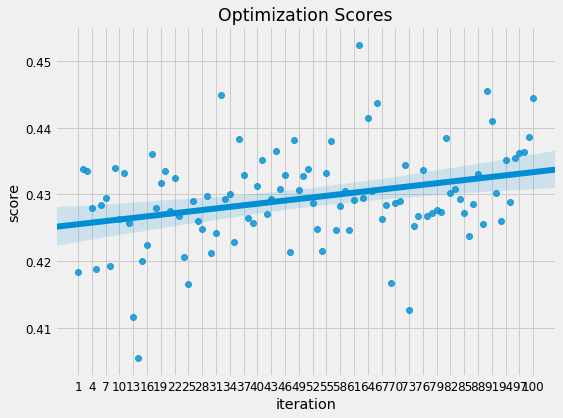

In [77]:
plt.figure(figsize = (8, 6))
sns.regplot('iteration', 'score', data = results);
plt.title("Optimization Scores");
plt.xticks(list(range(1, results['iteration'].max() + 1, 3)));

In [78]:
best_hyp = ast.literal_eval(results.loc[0, 'hyperparameters'])
best_hyp

{'boosting_type': 'dart',
 'colsample_bytree': 0.6656610653879056,
 'learning_rate': 0.15654386057087114,
 'limit_max_depth': False,
 'max_depth': -1,
 'min_child_samples': 25,
 'num_leaves': 28,
 'reg_alpha': 0.34028648714401466,
 'reg_lambda': 0.4969925318931504,
 'subsample_for_bin': 60000,
 'drop_rate': 0.39401307778070693,
 'subsample': 0.9522476606817002,
 'subsample_freq': 6,
 'n_estimators': 86}

In [83]:
%%capture
sub_gbm_opt_10fold_sel, gbm_fi_opt_10fold_sel, valid_scores = model_gbm(train_selected, train_labels, 
                                                                        test_selected, test_ids, 
                                                                        nfolds=10, hyp=best_hyp, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

In [16]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_on, train_labels, 
                                             test_on, test_ids, 
                                             nfolds=10, hyp=best_hyp, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)


NameError: name 'model_gbm' is not defined

In [84]:
model_results.head(10)

,cv_mean,cv_std,model
14,0.433122,0.024496,GBM_10Fold
15,0.425541,0.029268,GBM_10Fold_SEL
0,0.417161,0.028835,GBM_OPT_10Fold_SEL
0,0.414255,0.036250,GBM_OPT_10Fold
12,0.414023,0.014316,GBM
13,0.412712,0.009896,GBM_SEL
0,0.399565,0.032698,GBM_OPT_10Fold_SEL
11,0.355147,0.047267,RF-SEL
10,0.355147,0.047267,RF-SEL
9,0.340525,0.039503,RF


In [85]:
sub_gbm_opt_10fold_sel.to_csv('gbm_opt_10fold_selected.csv', index=False)

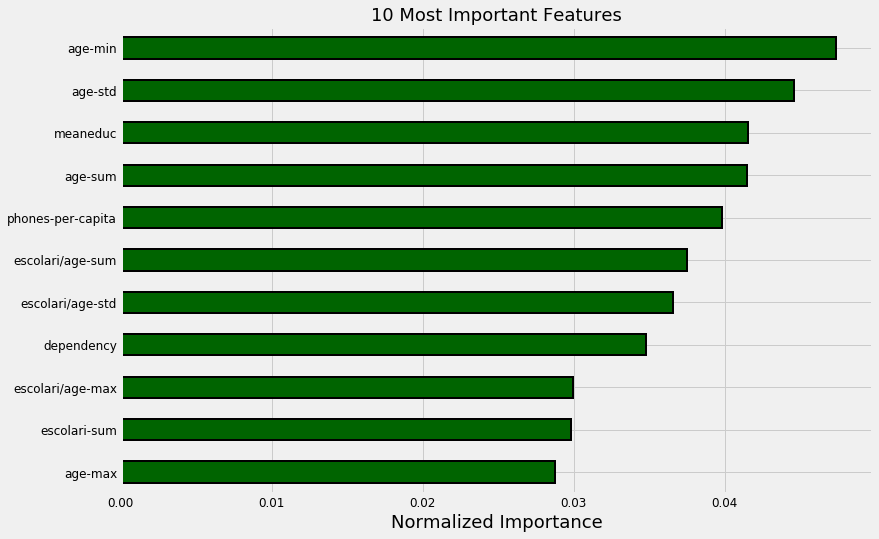

In [86]:
_ = plot_feature_importances(gbm_fi_opt_10fold_sel)

In [94]:
# Comparing the target variables across the training and testing set
preds = submission_base.merge(sub_gbm_opt_10fold_sel, on='Id', how='left')
preds = pd.DataFrame(preds.groupby('idhogar')['Target'].mean())
preds.shape

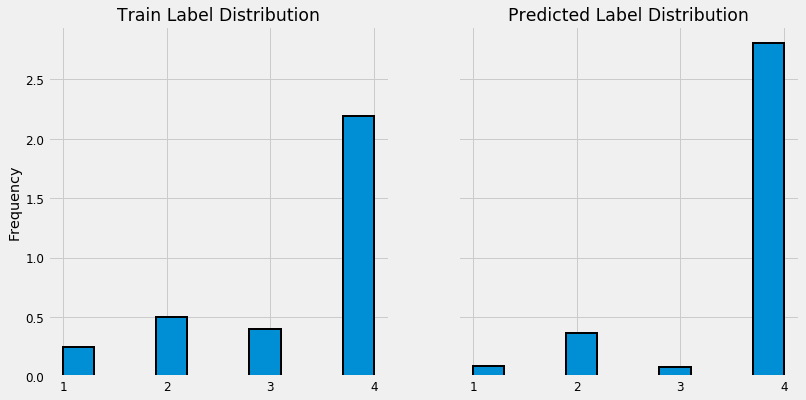

In [89]:
# Plot the training labels distribution
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (12, 6))
final['Target'].sort_index().plot.hist(normed = True,
                                       edgecolor = r'k',
                                       linewidth = 2,
                                       ax = axes[0])

axes[0].set_xticks([1, 2, 3, 4]);
axes[0].set_title('Train Label Distribution')

# Plot the predicted labels
preds['Target'].sort_index().plot.hist(normed = True, 
                                       edgecolor = 'k',
                                       linewidth = 2,
                                       ax = axes[1])
axes[1].set_xticks([1, 2, 3, 4]);
plt.subplots_adjust()
plt.title('Predicted Label Distribution');

In [100]:
final['Target'].value_counts()

4.0    1954
2.0     442
3.0     355
1.0     222
Name: Target, dtype: int64

In [101]:
preds['Target'].value_counts()

4    6187
2     820
1     180
3     165
Name: Target, dtype: int64

#### Notes:
- The predicted distribution looks close to the training distribution although there are some differences. Depending on the run of the notebook, the results you see may change, but for this edition, the 4s are underrepresented in the predictions and the 3s are overrepresented.
- One potentially method for dealing with imbalanced classification problems is oversampling the minority class, which is easy to do in Python using the imbalanced learn library. We won't explore that option here.

## Model Optimization: Train on the Validation Set

In [102]:
from sklearn.model_selection import train_test_split

# Split into validation set
X_train, X_valid, y_train, y_valid = train_test_split(train_selected,
                                                      train_labels,
                                                      test_size = 1000,
                                                      random_state = 10)

# Create model and train
model = lgb.LGBMClassifier(**best_hyp, 
                           class_weight = 'balanced',
                           random_state = 10)
model.fit(X_train, y_train);

In [103]:
# Make validation predictions
valid_preds = model.predict_proba(X_valid)
preds_df = pd.DataFrame(valid_preds, columns = [1, 2, 3, 4])

# Convert into predictions
preds_df['prediction'] = preds_df[[1, 2, 3, 4]].idxmax(axis = 1)
preds_df['confidence'] = preds_df[[1, 2, 3, 4]].max(axis = 1)

preds_df.head()

,1,2,3,4,prediction,confidence
0,0.092974,0.070449,0.048534,0.788043,4,0.788043
1,0.030688,0.034598,0.026426,0.908289,4,0.908289
2,0.040777,0.111144,0.390535,0.457544,4,0.457544
3,0.217870,0.409564,0.289867,0.082700,2,0.409564
4,0.058482,0.225054,0.600872,0.115592,3,0.600872


In [104]:
print('F1 score:', round(f1_score(y_valid, preds_df['prediction'], average = 'macro'), 5))


F1 score: 0.43528


In [105]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 26  18  17  19]
 [ 23  53  30  33]
 [ 13  24  38  38]
 [ 19  69  80 500]]


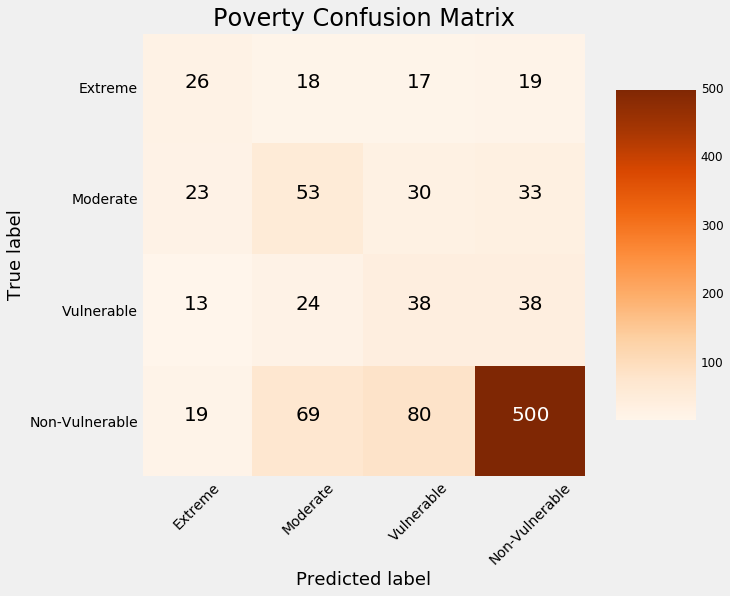

In [106]:
cm = confusion_matrix(y_valid, preds_df['prediction'])

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

#### Notes:
- Any values in the diagnoal are responses we got right. Any value not on the diagnol can be disected by viewing the true and what we predicted!

Normalized confusion matrix
[[0.325      0.225      0.2125     0.2375    ]
 [0.16546763 0.38129496 0.21582734 0.23741007]
 [0.11504425 0.21238938 0.33628319 0.33628319]
 [0.02844311 0.10329341 0.11976048 0.74850299]]


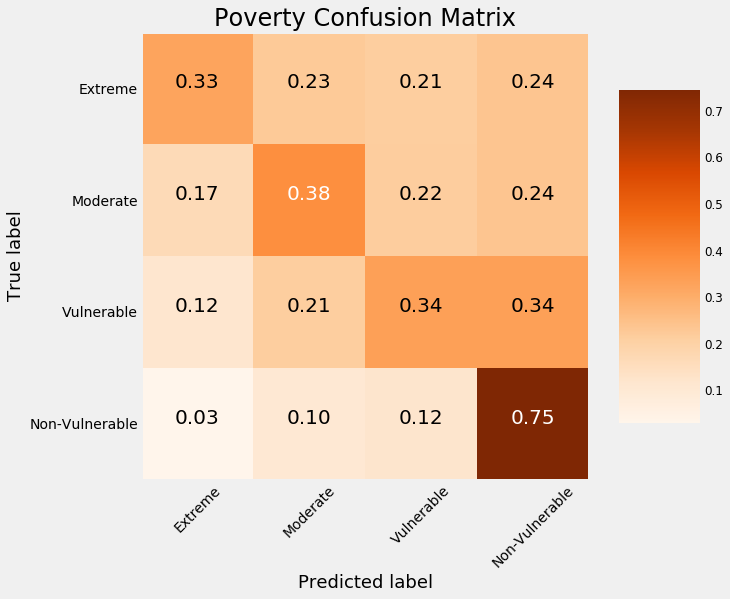

In [107]:
plot_confusion_matrix(cm, normalize = True,
                      classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

#### Notes:
- Now we can see that our model really does not do that well for classes other than Non Vulnerable.
- Overall, these results show that imbalanced classification problems with relatively few observations are very difficult. There are some methods we can take to try and counter this such as oversampling or training multiple models on different sections of the data, but at the end of the day, the most effective method may be to gather more data.

In [109]:
# Saving Models for advances techniques
train_selected.to_pickle('./pickles/train_selected.pkl')
test_selected.to_pickle('./pickles/test_selected.pkl')